<a href="https://colab.research.google.com/github/HARASEON/ML_class/blob/main/ML_Final_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Final Project
### Version 2 K-NN (K Nearest Neighbor)

without using sklearn


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##**0. Design**
- Aim of the experiments : building classification model
  - K-NN
- Churn data
  - It has a labeled sample for training => **Supervised learning**
  - It need to classify into three parts(angry, happy, surprised) => **Classification >> Stochastic model**
  - It has 10 Features => **multivariate learning**
  

##**1. Data Loading**

> Indented block


- Data loading by pandas module and using read_csv method
- Data spliting into three part, which is train, validation and test sets by using slice function in python


In [ ]:
import io
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn
import math
from sklearn.preprocessing import RobustScaler
from zlib import crc32
from collections import Counter
from pandas.plotting import scatter_matrix

%matplotlib inline


# Data loading for exploration
# Please input your data path
def data_load_exp(path):
  '''
  # Data loading
  - loading data
  - spliting the three set of data
  - path format 
  ex.
  '/content/drive/My Drive/exam_for_ML/Churn_Modelling_Age.csv' 
  '''
  origin_data = pd.read_csv(path) #skiprows=[0])
  data = pd.DataFrame(origin_data)
  gender = data[['Gender']]
  by_gender = []
  for i in range(len(gender)):
    a = gender.loc[i, 'Gender']
    if a == 'Female':
      a = 1
      by_gender.append(a)
    elif a == 'Male':
      a = 0
      by_gender.append(a)
    else:
      print("error!")
  
  data['Gender'] = by_gender
  return data

# Data loading for ML
def data_load(path):
  '''
  # Data loading
  - loading data
  - spliting the three set of data 
  - path format 
  ex.
  '/content/drive/My Drive/exam_for_ML/Churn_Modelling.csv' 
  '''
  origin_data = pd.read_csv(path, header=None, skiprows=[0])
  data = pd.DataFrame(origin_data)
  return data

In [ ]:
# Female = 0 Male = 1

X_explor= data_load_exp('/content/drive/My Drive/exam_for_ML/Churn_Modelling.csv')
X = data_load('/content/drive/My Drive/exam_for_ML/Churn_Modelling.csv')

X_exp = X_explor.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography', 'EstimatedSalary','NumOfProducts'], axis=1) #Geograpy 빼기 #age category
for geoname in np.unique(X_explor.Geography):
  X_exp[geoname] = (X_explor.Geography == geoname).astype('int')
X_exp = X_exp.drop(['Exited'], axis=1)
X_exp['Exited'] = X_explor.Exited
X_exp

,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,France,Germany,Spain,Exited
0,619,1,42,2,0.00,1,1,1,0,0,1
1,608,1,41,1,83807.86,0,1,0,0,1,0
2,502,1,42,8,159660.80,1,0,1,0,0,1
3,699,1,39,1,0.00,0,0,1,0,0,0
4,850,1,43,2,125510.82,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,1,0,1,0,0,0
9996,516,0,35,10,57369.61,1,1,1,0,0,0
9997,709,1,36,7,0.00,0,1,1,0,0,1
9998,772,0,42,3,75075.31,1,0,0,1,0,1


In [ ]:
from sklearn.manifold import TSNE
X = np.array(X_exp)[:,:-1] # total dataset - label
Y = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

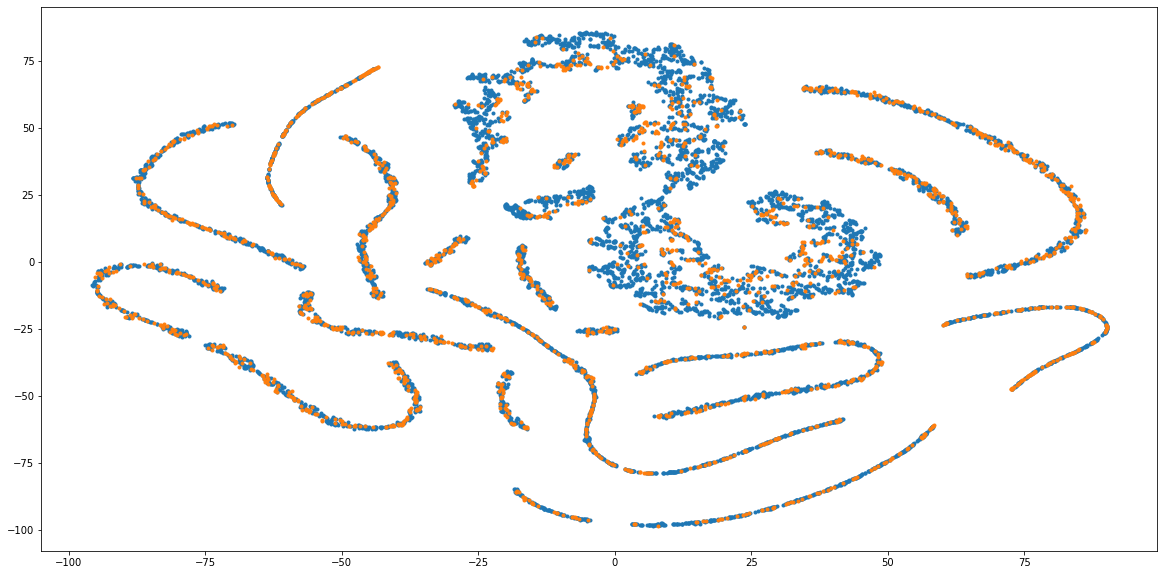

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
for i in range(2):
  idx = i == X_exp.Exited
  plt.plot(Y[idx,0],Y[idx,1],'.')
plt.show()

##**2. Data exploration**
First, To find out the correlation with each feature, calculate correlation of each features and drawing the scatter plot. Since the data set has 22 features which is too many to dawing in one plot, I just use some high correlation points.

**As you can see the second matrix titled "Feature 3 to Feature 1", it shows us the corrlation is quite strong(almost +1)and the points are clustered.**



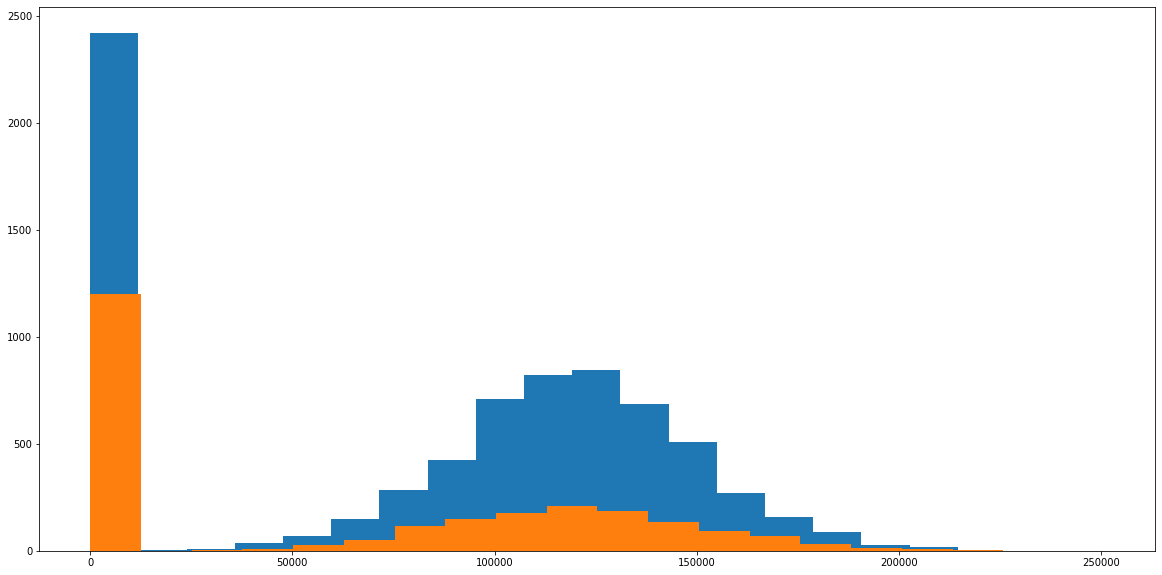

In [ ]:
plt.hist(X_explor['Balance'][X_exp.Spain==0],20)
plt.hist(X_explor['Balance'][X_exp.Spain==1],20)
plt.show()

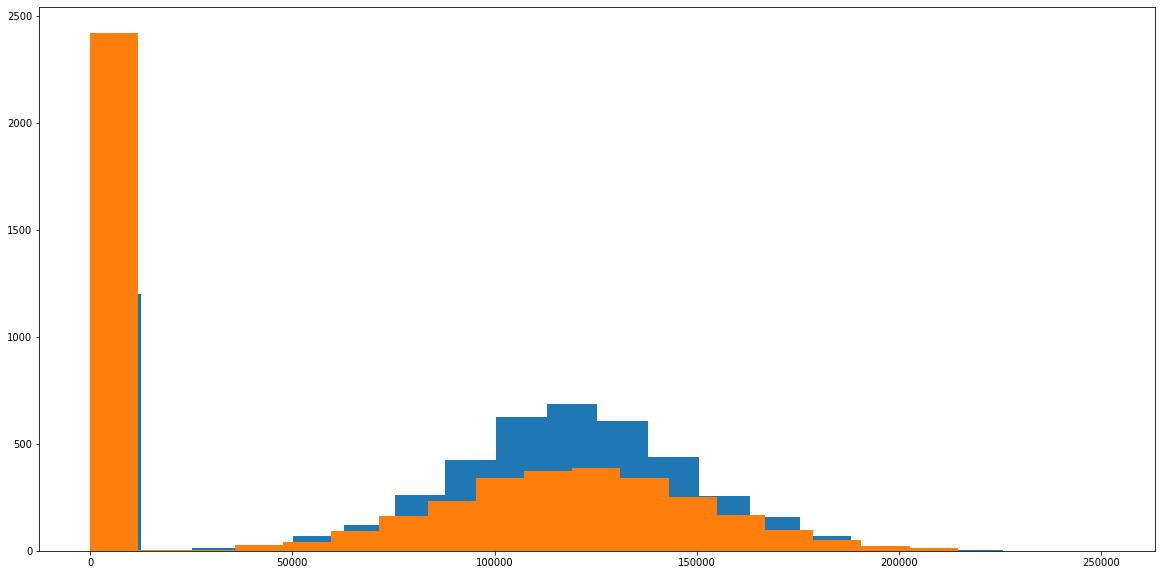

In [ ]:
plt.hist(X_explor['Balance'][X_exp.France==0],20)
plt.hist(X_explor['Balance'][X_exp.France==1],20)
plt.show()

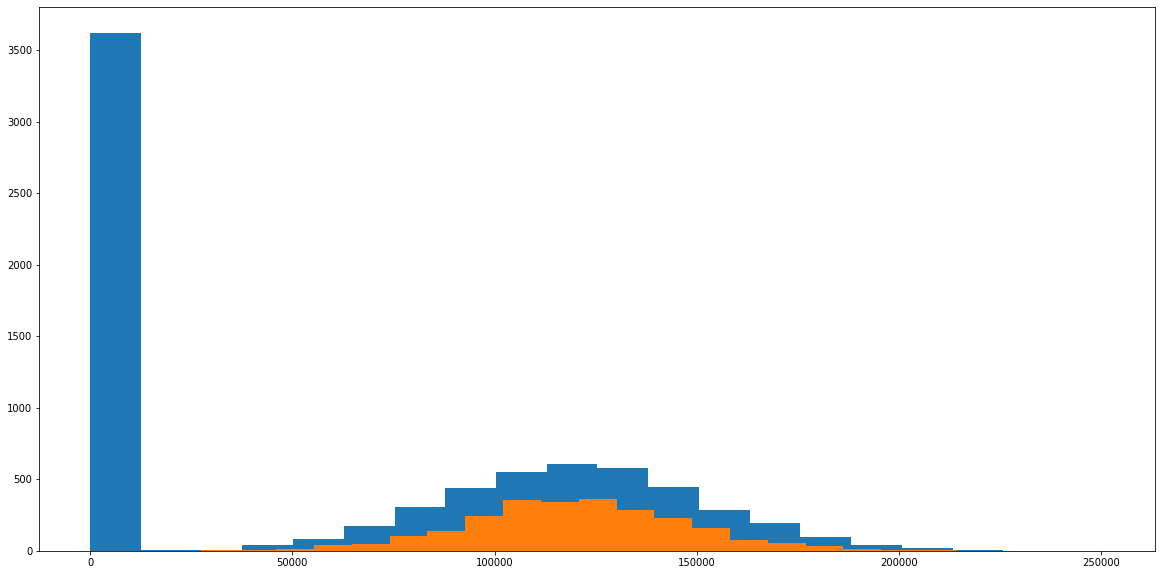

In [ ]:
plt.hist(X_explor['Balance'][X_exp.Germany==0],20)
plt.hist(X_explor['Balance'][X_exp.Germany==1],20)
plt.show()

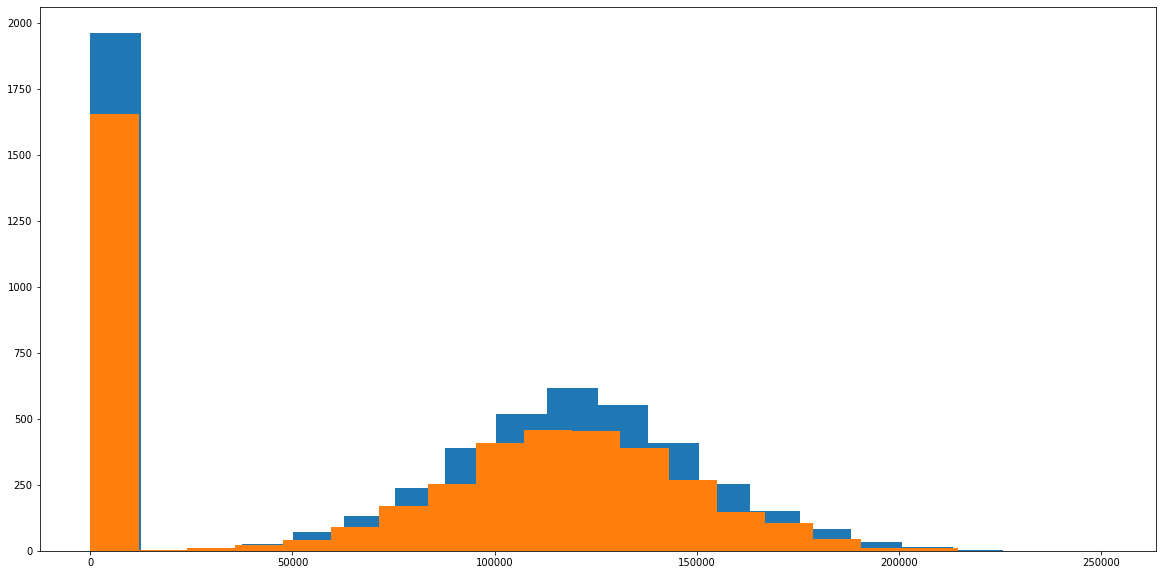

In [ ]:
plt.hist(X_explor['Balance'][X_exp.Gender==0],20)
plt.hist(X_explor['Balance'][X_exp.Gender==1],20)
plt.show()

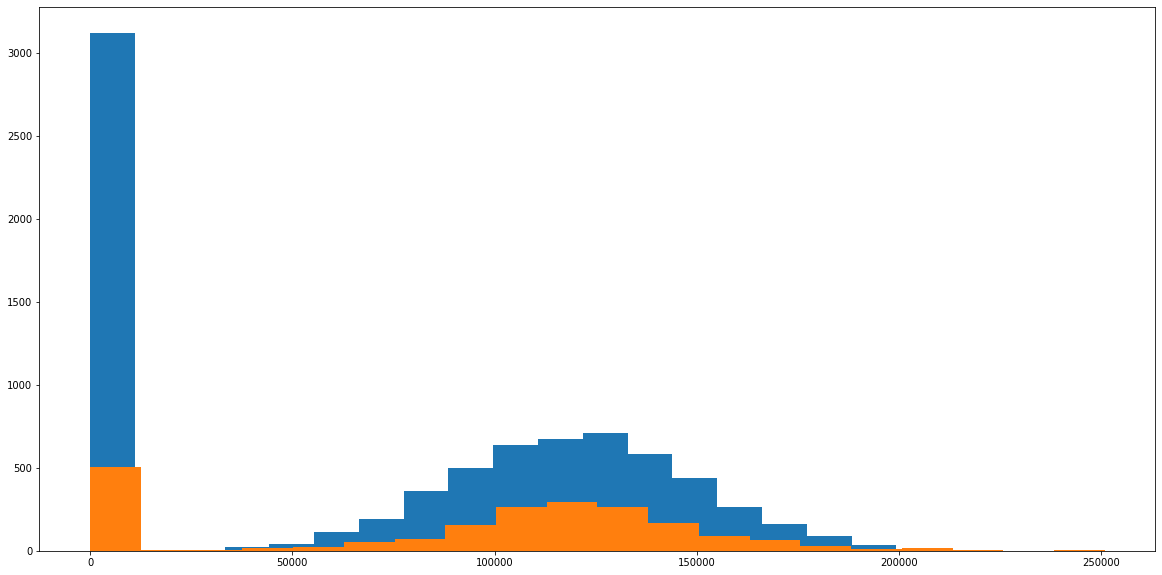

In [ ]:
plt.hist(X_explor['Balance'][X_exp.Exited==0],20)
plt.hist(X_explor['Balance'][X_exp.Exited==1],20)
plt.show()

In [ ]:
# Correlation (Standard : Balance = 1) 
# From the result, Balance has a deeply related to exited rate.
corr_matrix = X_exp.corr()
print(corr_matrix['Exited'].sort_values(ascending=False)) 

# Show scatter plot matrix
attributes = ['Age', 'Balance', 'Germany', 'Gender']
scatter_matrix(X_exp[attributes], figsize=(12, 8))

# # maginify the Feature 3 that has the largest correlation value among other features.
X_exp.plot(title = " Age to Exited", kind = "scatter", x = "Age", y = "Exited")

Exited            1.000000
Age               0.285323
Germany           0.173488
Balance           0.118533
Gender            0.106512
HasCrCard        -0.007138
CreditScore      -0.027094
Spain            -0.052667
France           -0.104955
IsActiveMember   -0.156128
Name: Exited, dtype: float64


KeyError: ignored

##**3. Data preprocessing**
1) Data spliting & Label Extraction
1. Shuffling the data 
2. Dividing the data set into three parts.
- train_set: test_set  = 6 : 4
- y_train, y_test = 6 : 4

In [ ]:
# Data spliting
np.random.seed(42)

def split_train_test(data, test_ratio):
  '''
  spliting train set and test set
  '''
  shuffled_indices = np.random.permutation(data)
  test_set_size = int(len(data) * test_ratio)
  # val_set_size = int(len(data) * 0)
  train_indices = shuffled_indices[:test_set_size]
  # val_indices = shuffled_indices[test_set_size:test_set_size + val_set_size]
  test_indices = shuffled_indices[test_set_size:]
  # return train_indices, val_indices, test_indices
  return train_indices, test_indices

# train_set, val_set, test_set = split_train_test(X, 0.6)
train_set, test_set = split_train_test(X_exp, 0.8)

print(train_set.shape)
print(test_set.shape)

(8000, 11)
(2000, 11)


In [ ]:
y_train = train_set[:,-1]
y_test = test_set[:,-1]

print("y_train: ", y_train.shape, y_train)
print("y_test:", y_test.shape, y_test)

y_train:  (8000,) [0. 0. 0. ... 0. 0. 0.]
y_test: (2000,) [1. 1. 0. ... 1. 1. 0.]


##**3. Data preprocessing**
2) Data Scaling

Since the scale will be different for each column of data, it is necessary to go through a normalization process that converts the values of data in numerical form into 0-1.

- Standard scaler : transform all value with mean = 0 and variance 1 
- Z-score standardization : mean = 0, standard deviation = 1 -> standard normal distribution.
To avoid problem related with outlierm, use the strategy of regularization.
- x' = (x - mean)/standard deviation


In [ ]:
# Using robust scaler 
transformer = RobustScaler().fit(train_set)
transformer.transform(train_set)

array([[-0.41044776,  0.        , -0.41666667, ...,  1.        ,
         0.        ,  0.        ],
       [-0.20895522,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.37313433,  1.        ,  0.58333333, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.47014925,  0.        , -0.33333333, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.35820896,  0.        , -0.16666667, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98507463,  0.        , -0.25      , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
class StandardScaler:
    def __init__(self):
      '''
      define mean and std 
      '''
      self.mean_num = None
      self.std_num = None


    def fit_transform(self, data):
      '''
      apply standardization
      '''
      if data is None:
          print("fit_transform() missing 1 required positional argument: 'X'")
      self.mean_num = np.mean(data)
      self.std_num = np.std(data)

      # StandardScaler operating formula
      return (data - self.mean_num) / self.std_num

# generating instance 
SS= StandardScaler()

# Fitting scaler
x_train = np.array(train_set[:,:-1])
x_scaled_train = SS.fit_transform(x_train)
#val_set_temp = np.array(val_set)
#val_scaled = SS.fit_transform(val_set_temp)
x_test = np.array(test_set[:,:-1])
x_scaled_test = SS.fit_transform(x_test)
print(x_scaled_train)
print(x_scaled_test)

[[-0.23511592 -0.25486264 -0.25380242 ... -0.25486264 -0.25482951
  -0.25486264]
 [-0.23422135 -0.25486264 -0.25343796 ... -0.25482951 -0.25486264
  -0.25486264]
 [-0.23495026 -0.25482951 -0.25340483 ... -0.25486264 -0.25486264
  -0.25482951]
 ...
 [-0.23120633 -0.25486264 -0.25376929 ... -0.25486264 -0.25486264
  -0.25482951]
 [-0.23170331 -0.25486264 -0.25370302 ... -0.25482951 -0.25486264
  -0.25486264]
 [-0.23766709 -0.25486264 -0.25373615 ... -0.25482951 -0.25486264
  -0.25486264]]
[[-0.23629582 -0.25646196 -0.25433058 ... -0.25646196 -0.25649475
  -0.25649475]
 [-0.2374107  -0.25646196 -0.25518313 ... -0.25649475 -0.25646196
  -0.25649475]
 [-0.23406607 -0.25649475 -0.25541267 ... -0.25646196 -0.25649475
  -0.25649475]
 ...
 [-0.23239376 -0.25646196 -0.25524871 ... -0.25646196 -0.25649475
  -0.25649475]
 [-0.23462351 -0.25649475 -0.25508476 ... -0.25646196 -0.25649475
  -0.25649475]
 [-0.23363979 -0.25649475 -0.25482244 ... -0.25649475 -0.25646196
  -0.25649475]]


#**Model Selection**

##**4. Model Training/Prediction**


In [ ]:
from tqdm import tqdm
# Model tuning
  # Using KNN
  # k = 9
debug = False

class KnnClassifier:
    
    def __init__(self, n_neighbors=3): # generate instances
      """최근접 이웃으로 선택할 개수를 저장함."""
      self.k = n_neighbors

    def fit(self, X_train, y_label): # 모델 훈련
      """레이블을 가지고 있는 데이터(point)를 저장함."""
      self.points = X_train
      self.labels = y_label

    def distance(self, X, y):
      """점(벡터) y와 점(벡터)들 X의 거리들의 배열을 리턴"""
      if debug: print('print distance:', np.sqrt(np.sum((X - y) ** 2, axis=1)))
      return np.sqrt(np.sum((X - y) ** 2, axis=1))

    def majority_vote(self, distances):
      # 거리 순서로 정렬된 인덱스를 찾는다. -> np.argsort 함수
      #indices_by_distance = np.argsort(distances)
      if debug: print(len(distances))
      indices_by_distance = distances.argsort()
      if debug: print('indices_by_distance:', indices_by_distance)
      # 가장 가까운 k개의 레이블을 찾는다.
      k_nearest_neighbor = []
      for i in range(self.k):
          idx = indices_by_distance[i]
          k_nearest_neighbor.append(self.labels[idx])
      # for i, dist in enumerate(indices_by_distance[0:self.k]):       
      #     k_nearest_neighbor.append(self.labels[i])
      if debug: print('k_nearest_neighbor: ',k_nearest_neighbor)
      # 가장 많은 득표를 얻은 레이블을 찾는다.
      vote_counts = Counter(k_nearest_neighbor)
      if debug: print('vote_counts: ', vote_counts)

      # most_common(n): 가장 많은 빈도수 n순위까지의 리스트
      # 빈도수가 동률일 수도 있다
      if debug: print('vote_counts.most_common(2): ', vote_counts.most_common(2)) # 2등까지 출력
      winner, winner_count = vote_counts.most_common(1)[0]
      return winner

    def predict(self, X_test): # 예측
      """테스트 세트 X_test의 각 점들마다,
      1) 학습 세트에 있는 모든 점들과의 거리를 계산.
      2) 계산된 거리들 중에서 가장 짧은 거리 k개를 선택.
      3) k개 선택된 레이블들 중에서 가장 많은 것(다수결)을 예측값으로 함."""
      if debug: print(len(X_test))
      predicts = [] # 예측값들을 저장할 리스트
      for test_pt in tqdm(X_test): # 테스트 세트에 있는 점들의 개수만큼 반복
          # 학습 세트의 점들과의 거리를 계산
          distances = self.distance(self.points, test_pt)
          if debug: print(test_pt)
          if debug: print(distances)
          # 다수결로 예측값 결정
          winner = self.majority_vote(distances)      
          # 예측값을 리스트에 저장
          predicts.append(winner)

      return np.array(predicts) # 예측값들의 배열을 리턴


In [ ]:
print(x_scaled_train.shape)
print(X_exp.shape)

(8000, 10)
(10000, 11)


In [ ]:
knn = KnnClassifier(n_neighbors=10) # k-NN 분류기 객체 생성 - 생성자 호출
print('k =', knn.k)
print(len(x_scaled_train))
knn.fit(x_scaled_train, y_train)
y_pred = knn.predict(x_scaled_test)
print('y_pred: ',y_pred)

#y_pred2 = knn.predict(val_scaled)

eval = y_pred == y_test
accuracy = sum(eval) / len(eval)
print("accuracy of KNN:", accuracy) # accuracy is around 95%

k = 10
8000


100%|██████████| 2000/2000 [00:02<00:00, 766.67it/s]

y_pred:  [0. 1. 0. ... 0. 0. 0.]
accuracy of KNN: 0.7815


##**4. Model training** 

##**5. Performance evaluation**
- ACC = (TP + TN)/(TP + TN + FP + FN) = 1 - ERR
- Precesion = TP / (TP + FP)
  - standard : model's prediction 
- Recall = TP/ (TP + FN)
  - standard : data
- macro-F1 = {2 *(precision * recall)} / (precision + recall)


In [ ]:
from sklearn.metrics import confusion_matrix

def make_confusion(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion,columns=['Predicted_Negative','Predicted_Positive'],index=['Actual_Negative','Actual_Positive'])
    
    return confusion_df

make_confusion(y_test,y_pred)



,Predicted_Negative,Predicted_Positive
Actual_Negative,3120,73
Actual_Positive,777,30


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score 

def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Accuracy:{0:.4f}, Recall:{1:.4f}, Precision:{2:.4f}, F1-Score:{3:.4f}'.format(accuracy, recall, precision, f1))

get_clf_eval(y_test, y_pred)

Accuracy:0.7875, Recall:0.0372, Precision:0.2913, F1-Score:0.0659


In [ ]:
# Performance evaluation
# Confusion matrix
# ACC(accuracy), precision, recall, macro-F1
from numpy import logical_and as and_
from numpy import logical_or as or_
from numpy import logical_not as not_

# y_pred = np.array([1,2,3,1,2,3,1,2,1,3])
# y_true = np.array([1,2,3,1,2,3,1,2,1,3])

def compute_tpfn(y_pred, y_true):
  '''
  Args: 
      y_pred : label data modeled by RDA
      y_true : correct answer data
      target_label : 1,2 and 3 can be input
  Returns:
      Depending on traget_label, it will be different 
  '''
  pos = sum(y_pred == y_true)
  neg = sum(y_pred != y_true)
  idx_tp = and_(pos, y_pred == y_true)
  idx_fp = and_(neg, not_(y_pred == y_true))
  idx_tn = and_(pos, y_pred == y_true)
  idx_fn = and_(neg, not_(y_pred == y_true))
  
  tp = idx_tp.sum()
  fp = idx_fp.sum()
  tn = idx_tn.sum()
  fn = idx_fn.sum()

  return tp, fp, tn, fn


def macro_f1(y_pred, y_true):
  '''
  Contents:
      When real == predicted & result = correct True_positive 
      When real != predicted & result = flase True_negative
      When real == predicted & result = false False_negitive
      When real != predicted & result = correct False_positive
      prediction = [1,2,3]
  
  Returns:
      - Depending on traget_label, it will be different 
      - You can start with guessing the lable that lead to get accuracy, precision, recall 
        and macro_F1 for your guessing label(answer)
  '''
  guess_ans = np.unique(y_true)
  sum_f1 = 0
  
  for answer in guess_ans: # 1,0
    tp, fp, tn, fn = compute_tpfn(y_pred, y_true)
    pre = precision(tp,fp)
    rec = recall(tp, fn)
    sum_f1 += 2*pre*rec/(pre+rec)

  return sum_f1 / len(guess_ans)
  
def accuracy(tp, tn, fn, fp): # put the output from compute_tpfn 
  '''
  Accuracy = (tp + tn) /(fp + fn + tp + tn) 
  '''
  return (tp + tn)/ float(tp + tn + fn + fp)


def precision(tp, fp):
  '''
  Precision : tp / (tp + fp)
  '''
  return tp /float(tp + fp)


def recall(tp, fn):
  '''
  Recall = tp/ (tp + fn)
  '''
  return tp/float(tp + fn)

def test_evaluation(test_predict, y_test):
    print("----------------------------")
    tp, fp, tn, fn = compute_tpfn(test_predict, y_test) # i is what you guess for the test_label, so that it cane be 1,2,3
    print( "tp, fp, tn, fn:", tp, fp, tn, fn)
    accuracy_score = accuracy(tp, tn, fn, fp)
    precision_score = precision(tp, fp)
    recall_score = recall(tp, fn)
    macro_F1 = macro_f1(test_predict, y_test)
    print("macro_F1:", macro_F1)
    print("accuracy_score", accuracy_score)
    print("recall_score:", recall_score)
    print("----------------------------")

test_evaluation(y_pred,y_test)

----------------------------
tp, fp, tn, fn: 3150 850 3150 850
macro_F1: 0.7875
accuracy_score 0.7875
recall_score: 0.7875
----------------------------
